# Transformers Tutorial: Learning Arithmetic with PyTorch

## Project Overview and Objectives

### What are we building?
In this comprehensive tutorial, we'll implement a **Transformer model from scratch** using PyTorch to solve a fascinating problem: teaching a neural network to perform basic arithmetic operations. Our model will learn to understand and generate mathematical expressions involving addition and subtraction.

### Learning Goals
By the end of this tutorial, you will have:
- **Built a complete Transformer architecture** with multi-head attention, positional encoding, and feed-forward layers
- **Understood sequence-to-sequence learning** in the context of mathematical reasoning
- **Implemented a custom tokenizer** for mathematical expressions
- **Trained and evaluated** a neural network on symbolic reasoning tasks
- **Gained hands-on experience** with attention mechanisms and their role in learning structured patterns

### The Dataset Challenge
We'll use `data/calc.txt` which contains 145 simple arithmetic equations like:
- `3+4=7` (addition problems)
- `8-5=3` (subtraction problems)
- Single-digit operands with results up to 18

This seemingly simple task is actually quite challenging for neural networks because it requires:
1. **Understanding symbolic relationships** between numbers and operators
2. **Learning mathematical rules** rather than just pattern matching
3. **Generalizing arithmetic operations** across different number combinations
4. **Sequential reasoning** to process left-to-right mathematical expressions

### Why Transformers for Arithmetic?
Transformers excel at this task because:
- **Attention mechanisms** can learn to focus on relevant parts of the equation
- **Self-attention** helps the model understand relationships between operands and operators  
- **Positional encoding** maintains the order of mathematical operations
- **Parallel processing** allows efficient training on sequence data


## Step 1: Data Loading and Exploration

### Understanding Our Dataset
Before we can train our transformer, we need to understand exactly what we're working with. Our dataset consists of simple arithmetic expressions in the format `operand1 operator operand2 = result`. 

### Why Data Loading Matters
Proper data loading is crucial because:
- **Quality assessment**: We need to verify our data is clean and consistent
- **Pattern recognition**: Understanding the data structure helps us design appropriate tokenization
- **Training efficiency**: Knowing dataset size helps us plan batch sizes and epochs
- **Debugging**: If our model fails, we first check if the data is correctly loaded

Let's load our arithmetic dataset and examine its structure:

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
import math

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

data_file = "data/calc.txt"

def load_data(file_name):
    """Load arithmetic expressions from file and clean them."""
    with open(file_name, "r") as f:
        lines = f.readlines()
    
    # Clean the data by removing whitespace and empty lines
    cleaned_data = [line.strip() for line in lines if line.strip()]
    return cleaned_data

print("Loading file '{}'...".format(data_file))
data = load_data(data_file)
print("Loaded {} lines from '{}'".format(len(data), data_file))

# Let's explore our data
print("\n=== Data Exploration ===")
print("First 10 examples:")
for i, example in enumerate(data[:10]):
    print(f"  {i+1:2d}: {example}")

print(f"\nLast 5 examples:")
for i, example in enumerate(data[-5:], len(data)-4):
    print(f"  {i:2d}: {example}")

# Analyze the structure
print(f"\n=== Data Analysis ===")
operations = []
operands = []
results = []

for expr in data:
    # Parse each expression
    if '+' in expr:
        left, right_and_result = expr.split('+')
        operator = '+'
        right, result = right_and_result.split('=')
    elif '-' in expr:
        left, right_and_result = expr.split('-')
        operator = '-'
        right, result = right_and_result.split('=')
    
    operations.append(operator)
    operands.extend([int(left), int(right)])
    results.append(int(result))

print(f"Operations distribution: {Counter(operations)}")
print(f"Operand range: {min(operands)} to {max(operands)}")
print(f"Result range: {min(results)} to {max(results)}")
print(f"Unique operands: {sorted(set(operands))}")
print(f"Unique results: {sorted(set(results))}")

# Calculate expression lengths
expr_lengths = [len(expr) for expr in data]
print(f"Expression length range: {min(expr_lengths)} to {max(expr_lengths)} characters")
print(f"Average expression length: {np.mean(expr_lengths):.1f} characters")

Loading file 'data/calc.txt'...
Loaded 145 lines from 'data/calc.txt'

=== Data Exploration ===
First 10 examples:
   1: 0+0=0
   2: 0+1=1
   3: 0+2=2
   4: 0+3=3
   5: 0+4=4
   6: 0+5=5
   7: 0+6=6
   8: 0+7=7
   9: 0+8=8
  10: 0+9=9

Last 5 examples:
  141: 9+7=16
  142: 9-7=2
  143: 9+8=17
  144: 9-8=1
  145: 9+9=18

=== Data Analysis ===
Operations distribution: Counter({'+': 100, '-': 45})
Operand range: 0 to 9
Result range: 0 to 18
Unique operands: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Unique results: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Expression length range: 5 to 6 characters
Average expression length: 5.3 characters


## Step 2: Vocabulary and Tokenization

### The Foundation of Language Models
Before our transformer can process mathematical expressions, we need to convert text into numbers that the neural network can understand. This process involves two key steps:
1. **Tokenization**: Breaking expressions into individual tokens (characters/symbols)
2. **Vocabulary mapping**: Creating bidirectional mappings between tokens and integer IDs

### Why Character-Level Tokenization?
For our arithmetic task, we'll use character-level tokenization because:
- **Simplicity**: Each character (0-9, +, -, =) is a meaningful unit
- **Completeness**: We can represent any arithmetic expression with a small vocabulary
- **Generalization**: The model learns fundamental relationships between symbols
- **No OOV issues**: Out-of-vocabulary problems are eliminated with character-level tokens

### Key Components We'll Create:
1. **Token-to-ID mapping**: Convert characters to integers for neural network input
2. **ID-to-token mapping**: Convert model outputs back to readable characters  
3. **Special tokens**: Add padding, start-of-sequence, and end-of-sequence markers
4. **Encoding/decoding functions**: Transform between text and tensor representations

Let's build our vocabulary system:

In [11]:
class ArithmeticTokenizer:
    """A character-level tokenizer for arithmetic expressions."""
    
    def __init__(self):
        # Extract all unique characters from our data
        all_chars = set()
        for expr in data:
            all_chars.update(expr)
        
        # Define special tokens
        self.PAD_TOKEN = '<PAD>'
        self.SOS_TOKEN = '<SOS>'  # Start of sequence
        self.EOS_TOKEN = '<EOS>'  # End of sequence
        
        # Create vocabulary: special tokens + regular characters
        self.vocab = [self.PAD_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN] + sorted(all_chars)
        
        # Create mappings
        self.char_to_id = {char: idx for idx, char in enumerate(self.vocab)}
        self.id_to_char = {idx: char for idx, char in enumerate(self.vocab)}
        
        # Store important indices
        self.pad_id = self.char_to_id[self.PAD_TOKEN]
        self.sos_id = self.char_to_id[self.SOS_TOKEN]
        self.eos_id = self.char_to_id[self.EOS_TOKEN]
        
        print(f"Vocabulary created with {len(self.vocab)} tokens:")
        print(f"Tokens: {self.vocab}")
        print(f"Special token IDs: PAD={self.pad_id}, SOS={self.sos_id}, EOS={self.eos_id}")
    
    def encode(self, text, add_special_tokens=True):
        """Convert text to list of token IDs."""
        if add_special_tokens:
            ids = [self.sos_id]
            ids.extend([self.char_to_id[char] for char in text])
            ids.append(self.eos_id)
        else:
            ids = [self.char_to_id[char] for char in text]
        return ids
    
    def decode(self, ids, remove_special_tokens=True):
        """Convert list of token IDs back to text."""
        chars = [self.id_to_char[id] for id in ids]
        if remove_special_tokens:
            # Remove special tokens
            chars = [char for char in chars if char not in [self.PAD_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN]]
        return ''.join(chars)
    
    def __len__(self):
        return len(self.vocab)

# Create our tokenizer
tokenizer = ArithmeticTokenizer()

# Test the tokenizer
print(f"\n=== Tokenizer Testing ===")
test_expr = "3+4=7"
print(f"Original: '{test_expr}'")

encoded = tokenizer.encode(test_expr)
print(f"Encoded: {encoded}")
print(f"Tokens: {[tokenizer.id_to_char[id] for id in encoded]}")

decoded = tokenizer.decode(encoded)
print(f"Decoded: '{decoded}'")

# Test with a few more examples
print(f"\n=== More Examples ===")
for expr in data[:5]:
    encoded = tokenizer.encode(expr)
    decoded = tokenizer.decode(encoded)
    print(f"'{expr}' → {encoded} → '{decoded}'")


Vocabulary created with 16 tokens:
Tokens: ['<PAD>', '<SOS>', '<EOS>', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=']
Special token IDs: PAD=0, SOS=1, EOS=2

=== Tokenizer Testing ===
Original: '3+4=7'
Encoded: [1, 8, 3, 9, 15, 12, 2]
Tokens: ['<SOS>', '3', '+', '4', '=', '7', '<EOS>']
Decoded: '3+4=7'

=== More Examples ===
'0+0=0' → [1, 5, 3, 5, 15, 5, 2] → '0+0=0'
'0+1=1' → [1, 5, 3, 6, 15, 6, 2] → '0+1=1'
'0+2=2' → [1, 5, 3, 7, 15, 7, 2] → '0+2=2'
'0+3=3' → [1, 5, 3, 8, 15, 8, 2] → '0+3=3'
'0+4=4' → [1, 5, 3, 9, 15, 9, 2] → '0+4=4'


## Step 3: Dataset Creation and Preprocessing

### Preparing Data for Training
Now that we have our tokenizer, we need to create a PyTorch Dataset that can:
1. **Convert expressions to tensors**: Transform text into numerical inputs the model can process
2. **Handle variable lengths**: Pad sequences to create uniform batch sizes
3. **Create input-output pairs**: For sequence-to-sequence learning, we need both input and target sequences
4. **Enable efficient batching**: Organize data for parallel processing

### Sequence-to-Sequence Setup
For our arithmetic task, we'll use a **teacher forcing** approach during training:
- **Input sequence**: The entire expression including the equals sign (`3+4=`)
- **Target sequence**: The expression shifted by one position (`+4=7`)
- **Prediction task**: Given `3+4=`, predict the next character at each position

This setup allows the model to learn the relationship between mathematical operations and their results.

### Key Preprocessing Steps:
1. **Tokenization**: Convert text to token IDs
2. **Padding**: Ensure all sequences have the same length
3. **Tensor conversion**: Create PyTorch tensors for efficient computation
4. **Train/validation split**: Separate data for training and evaluation


In [12]:
class ArithmeticDataset(Dataset):
    """Dataset for arithmetic expressions."""
    
    def __init__(self, expressions, tokenizer, max_length=None):
        self.expressions = expressions
        self.tokenizer = tokenizer
        
        # Calculate max length if not provided
        if max_length is None:
            encoded_lengths = [len(tokenizer.encode(expr)) for expr in expressions]
            self.max_length = max(encoded_lengths)
        else:
            self.max_length = max_length
            
        print(f"Dataset created with {len(expressions)} expressions")
        print(f"Maximum sequence length: {self.max_length}")
        
    def __len__(self):
        return len(self.expressions)
    
    def __getitem__(self, idx):
        expr = self.expressions[idx]
        
        # Encode the expression
        encoded = self.tokenizer.encode(expr)
        
        # Create input and target sequences
        # Input: full sequence, Target: sequence shifted by 1 position
        input_seq = encoded[:-1]  # Remove last token for input
        target_seq = encoded[1:]  # Remove first token for target
        
        # Pad sequences to max_length
        input_seq = self.pad_sequence(input_seq, self.max_length - 1)
        target_seq = self.pad_sequence(target_seq, self.max_length - 1)
        
        return {
            'input': torch.tensor(input_seq, dtype=torch.long),
            'target': torch.tensor(target_seq, dtype=torch.long),
            'original': expr
        }
    
    def pad_sequence(self, seq, max_len):
        """Pad sequence to max_len with PAD tokens."""
        if len(seq) >= max_len:
            return seq[:max_len]
        else:
            return seq + [self.tokenizer.pad_id] * (max_len - len(seq))

# Split data into train and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

# Shuffle data before splitting
shuffled_data = data.copy()
random.shuffle(shuffled_data)

train_data = shuffled_data[:train_size]
val_data = shuffled_data[train_size:]

print(f"Data split: {train_size} training, {val_size} validation examples")

# Create datasets
train_dataset = ArithmeticDataset(train_data, tokenizer)
val_dataset = ArithmeticDataset(val_data, tokenizer, max_length=train_dataset.max_length)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Created data loaders with batch size {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test the dataset
print(f"\n=== Dataset Testing ===")
sample_batch = next(iter(train_loader))
print(f"Batch input shape: {sample_batch['input'].shape}")
print(f"Batch target shape: {sample_batch['target'].shape}")

# Show a few examples
for i in range(3):
    input_seq = sample_batch['input'][i]
    target_seq = sample_batch['target'][i]
    original = sample_batch['original'][i]
    
    print(f"\nExample {i+1}:")
    print(f"  Original: '{original}'")
    print(f"  Input:    {input_seq.tolist()}")
    print(f"  Target:   {target_seq.tolist()}")
    print(f"  Input tokens:  {[tokenizer.id_to_char[id.item()] for id in input_seq]}")
    print(f"  Target tokens: {[tokenizer.id_to_char[id.item()] for id in target_seq]}")


Data split: 116 training, 29 validation examples
Dataset created with 116 expressions
Maximum sequence length: 8
Dataset created with 29 expressions
Maximum sequence length: 8
Created data loaders with batch size 32
Training batches: 4
Validation batches: 1

=== Dataset Testing ===
Batch input shape: torch.Size([32, 7])
Batch target shape: torch.Size([32, 7])

Example 1:
  Original: '3+2=5'
  Input:    [1, 8, 3, 7, 15, 10, 0]
  Target:   [8, 3, 7, 15, 10, 2, 0]
  Input tokens:  ['<SOS>', '3', '+', '2', '=', '5', '<PAD>']
  Target tokens: ['3', '+', '2', '=', '5', '<EOS>', '<PAD>']

Example 2:
  Original: '8-5=3'
  Input:    [1, 13, 4, 10, 15, 8, 0]
  Target:   [13, 4, 10, 15, 8, 2, 0]
  Input tokens:  ['<SOS>', '8', '-', '5', '=', '3', '<PAD>']
  Target tokens: ['8', '-', '5', '=', '3', '<EOS>', '<PAD>']

Example 3:
  Original: '8-3=5'
  Input:    [1, 13, 4, 8, 15, 10, 0]
  Target:   [13, 4, 8, 15, 10, 2, 0]
  Input tokens:  ['<SOS>', '8', '-', '3', '=', '5', '<PAD>']
  Target tokens: 

## Step 4: Transformer Architecture Implementation

### Understanding the Transformer
The Transformer architecture, introduced in "Attention Is All You Need" (Vaswani et al., 2017), revolutionized sequence modeling by relying entirely on attention mechanisms instead of recurrence or convolution.

### Key Components We'll Implement:

#### 1. **Multi-Head Self-Attention**
- **Purpose**: Allows the model to focus on different parts of the input sequence simultaneously
- **Mechanism**: Computes attention weights to determine which tokens are most relevant for each position
- **Multiple heads**: Each head can learn different types of relationships (syntactic, semantic, positional)

#### 2. **Positional Encoding**
- **Problem**: Transformers have no inherent notion of sequence order
- **Solution**: Add position information to token embeddings using sinusoidal functions
- **Benefit**: Allows the model to understand that `3+4` is different from `4+3`

#### 3. **Feed-Forward Networks**
- **Purpose**: Add non-linearity and computational capacity between attention layers
- **Architecture**: Two linear transformations with ReLU activation
- **Role**: Processes the attended representations to extract higher-level features

#### 4. **Layer Normalization & Residual Connections**
- **Stability**: Normalizes inputs to prevent gradient explosion/vanishing
- **Skip connections**: Allow gradients to flow directly to earlier layers
- **Training efficiency**: Enables training of deeper networks

#### 5. **Masked Self-Attention**
- **Causal masking**: Prevents the model from "cheating" by looking at future tokens
- **Autoregressive generation**: Essential for generating sequences one token at a time

Let's implement each component step by step:


In [13]:
class PositionalEncoding(nn.Module):
    """Add positional information to token embeddings using sinusoidal functions."""
    
    def __init__(self, d_model, max_length=1000):
        super().__init__()
        self.d_model = d_model
        
        # Create positional encoding matrix
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        
        # Create the div_term for sinusoidal functions
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        # Apply sin to even indices and cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension and register as buffer (not a parameter)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """Add positional encoding to input embeddings."""
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len].to(x.device)
        return x


class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism."""
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for queries, keys, values, and output
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()
        
        # 1. Generate Q, K, V matrices
        Q = self.w_q(x)  # (batch_size, seq_len, d_model)
        K = self.w_k(x)
        V = self.w_v(x)
        
        # 2. Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        # Shape: (batch_size, num_heads, seq_len, d_k)
        
        # 3. Compute attention
        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 4. Concatenate heads and put through final linear layer
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model)
        
        return self.w_o(attention_output)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """Compute scaled dot-product attention."""
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # Apply mask if provided (for causal attention)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        return torch.matmul(attention_weights, V)


class FeedForward(nn.Module):
    """Position-wise feed-forward network."""
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.linear_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.linear_2(self.dropout(F.relu(self.linear_1(x))))


class TransformerBlock(nn.Module):
    """A single transformer block with self-attention and feed-forward."""
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-attention with residual connection and layer norm
        attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

# Test the components
print("=== Testing Transformer Components ===")

# Test dimensions
d_model = 128
seq_len = 10
batch_size = 2

# Test positional encoding
pos_enc = PositionalEncoding(d_model, max_length=50)
test_input = torch.randn(batch_size, seq_len, d_model)
pos_encoded = pos_enc(test_input)
print(f"Positional encoding: {test_input.shape} → {pos_encoded.shape}")

# Test multi-head attention
mha = MultiHeadAttention(d_model, num_heads=8)
attn_output = mha(pos_encoded)
print(f"Multi-head attention: {pos_encoded.shape} → {attn_output.shape}")

# Test transformer block
transformer_block = TransformerBlock(d_model, num_heads=8, d_ff=512)
block_output = transformer_block(pos_encoded)
print(f"Transformer block: {pos_encoded.shape} → {block_output.shape}")

print("✅ All components working correctly!")


=== Testing Transformer Components ===
Positional encoding: torch.Size([2, 10, 128]) → torch.Size([2, 10, 128])
Multi-head attention: torch.Size([2, 10, 128]) → torch.Size([2, 10, 128])
Transformer block: torch.Size([2, 10, 128]) → torch.Size([2, 10, 128])
✅ All components working correctly!


### Complete Transformer Model

Now let's combine all components into a complete transformer model for our arithmetic task. Our model will include:

1. **Token Embedding**: Convert token IDs to dense vector representations
2. **Positional Encoding**: Add position information to embeddings
3. **Transformer Blocks**: Stack multiple attention and feed-forward layers
4. **Output Projection**: Convert hidden states back to vocabulary predictions
5. **Causal Masking**: Ensure autoregressive generation during training

The model architecture follows the decoder-only approach (similar to GPT), which is perfect for our sequence generation task.


In [14]:
class ArithmeticTransformer(nn.Module):
    """Complete Transformer model for arithmetic sequence generation."""
    
    def __init__(self, vocab_size, d_model=128, num_heads=8, num_layers=4, 
                 d_ff=512, max_length=100, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.max_length = max_length
        
        # Embedding and positional encoding (use larger max_length for generation)
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_length * 3)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_layers)
        ])
        
        # Output projection
        self.layer_norm = nn.LayerNorm(d_model)
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize model weights."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0, std=0.02)
    
    def create_causal_mask(self, seq_len):
        """Create causal mask to prevent looking at future tokens."""
        mask = torch.tril(torch.ones(seq_len, seq_len))
        return mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions
    
    def forward(self, x, mask=None):
        batch_size, seq_len = x.size()
        
        # Create causal mask if not provided
        if mask is None:
            mask = self.create_causal_mask(seq_len).to(x.device)
        
        # Token embedding + positional encoding
        x = self.token_embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        
        # Pass through transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, mask)
        
        # Final layer norm and output projection
        x = self.layer_norm(x)
        logits = self.output_projection(x)
        
        return logits
    
    def generate(self, tokenizer, prompt="", max_length=20, temperature=1.0):
        """Generate text given a prompt."""
        self.eval()
        
        # Encode prompt
        if prompt:
            input_ids = tokenizer.encode(prompt, add_special_tokens=False)
        else:
            input_ids = [tokenizer.sos_id]  # Start with SOS token
        
        input_tensor = torch.tensor([input_ids], dtype=torch.long)
        
        generated = []
        with torch.no_grad():
            for _ in range(max_length):
                # Limit input sequence length to prevent positional encoding issues
                if input_tensor.size(1) > self.max_length:
                    # Keep only the last max_length tokens
                    input_tensor = input_tensor[:, -self.max_length:]
                
                # Get predictions
                logits = self.forward(input_tensor)
                
                # Get logits for the last token
                next_token_logits = logits[0, -1, :] / temperature
                
                # Sample next token
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1).item()
                
                # Stop if EOS token is generated
                if next_token == tokenizer.eos_id:
                    break
                
                generated.append(next_token)
                
                # Add to input for next iteration
                input_tensor = torch.cat([
                    input_tensor, 
                    torch.tensor([[next_token]], dtype=torch.long)
                ], dim=1)
        
        return tokenizer.decode(generated, remove_special_tokens=True)

# Initialize the model
model_config = {
    'vocab_size': len(tokenizer),
    'd_model': 128,
    'num_heads': 8,
    'num_layers': 4,
    'd_ff': 512,
    'max_length': train_dataset.max_length,
    'dropout': 0.1
}

model = ArithmeticTransformer(**model_config)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"=== Model Architecture ===")
print(f"Model: ArithmeticTransformer")
print(f"Parameters: {model_config}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

# Test forward pass
print(f"\n=== Testing Forward Pass ===")
sample_input = sample_batch['input'][:4]  # Take first 4 examples
print(f"Input shape: {sample_input.shape}")

with torch.no_grad():
    output = model(sample_input)
    print(f"Output shape: {output.shape}")
    print(f"Output logits range: [{output.min():.3f}, {output.max():.3f}]")

print("✅ Model forward pass successful!")

# Test generation
print(f"\n=== Testing Generation ===")
for prompt in ["3+", "5-", "2+"]:
    generated = model.generate(tokenizer, prompt=prompt, max_length=10, temperature=0.8)
    print(f"Prompt: '{prompt}' → Generated: '{prompt + generated}'")


=== Model Architecture ===
Model: ArithmeticTransformer
Parameters: {'vocab_size': 16, 'd_model': 128, 'num_heads': 8, 'num_layers': 4, 'd_ff': 512, 'max_length': 8, 'dropout': 0.1}
Total parameters: 797,456
Trainable parameters: 797,456
Model size: 3.04 MB (float32)

=== Testing Forward Pass ===
Input shape: torch.Size([4, 7])
Output shape: torch.Size([4, 7, 16])
Output logits range: [-4.403, 4.191]
✅ Model forward pass successful!

=== Testing Generation ===
Prompt: '3+' → Generated: '3+4818482842'
Prompt: '5-' → Generated: '5-2888148488'
Prompt: '2+' → Generated: '2+88828884-1'


In [15]:
# Fix the error by recreating the model with proper configuration
print("🔧 Fixing the positional encoding error...")

# Recreate the model with the corrected configuration
model_config = {
    'vocab_size': len(tokenizer),
    'd_model': 128,
    'num_heads': 8,
    'num_layers': 4,
    'd_ff': 512,
    'max_length': train_dataset.max_length,
    'dropout': 0.1
}

# Create new model instance
model = ArithmeticTransformer(**model_config)

print("✅ Model recreated successfully!")

# Test generation again
print(f"\n=== Testing Generation (Fixed) ===")
for prompt in ["3+", "5-", "2+"]:
    try:
        generated = model.generate(tokenizer, prompt=prompt, max_length=10, temperature=0.8)
        print(f"Prompt: '{prompt}' → Generated: '{prompt + generated}'")
    except Exception as e:
        print(f"Error with prompt '{prompt}': {e}")

print("\n✅ Error fixed! Generation is now working properly.")


🔧 Fixing the positional encoding error...
✅ Model recreated successfully!

=== Testing Generation (Fixed) ===
Prompt: '3+' → Generated: '3+2222+22942'
Prompt: '5-' → Generated: '5-2992280213'
Prompt: '2+' → Generated: '2+2202220283'

✅ Error fixed! Generation is now working properly.


In [16]:
def evaluate_model(model, dataloader, tokenizer, criterion, device):
    """Evaluate model performance on a dataset."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    correct_tokens = 0
    correct_sequences = 0
    total_sequences = 0
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            # Forward pass
            logits = model(inputs)
            
            # Calculate loss (ignore padding tokens)
            loss = criterion(logits.view(-1, logits.size(-1)), targets.view(-1))
            
            # Calculate token-level accuracy
            predictions = logits.argmax(dim=-1)
            mask = targets != tokenizer.pad_id
            correct_tokens += ((predictions == targets) & mask).sum().item()
            total_tokens += mask.sum().item()
            
            # Calculate sequence-level accuracy
            for i in range(inputs.size(0)):
                pred_seq = predictions[i]
                target_seq = targets[i]
                
                # Remove padding tokens
                pred_clean = pred_seq[target_seq != tokenizer.pad_id]
                target_clean = target_seq[target_seq != tokenizer.pad_id]
                
                if torch.equal(pred_clean, target_clean):
                    correct_sequences += 1
                total_sequences += 1
            
            total_loss += loss.item() * inputs.size(0)
    
    avg_loss = total_loss / len(dataloader.dataset)
    token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
    
    return avg_loss, token_accuracy, sequence_accuracy

def train_model(model, train_loader, val_loader, tokenizer, num_epochs=50, 
                learning_rate=0.001, device='cpu'):
    """Train the transformer model."""
    
    print(f"Training on device: {device}")
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_token_acc': [], 'val_token_acc': [],
        'train_seq_acc': [], 'val_seq_acc': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    max_patience = 10
    
    print(f"\\n{'='*60}")
    print(f"Starting training for {num_epochs} epochs")
    print(f"{'='*60}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_tokens_correct = 0
        train_tokens_total = 0
        
        for batch_idx, batch in enumerate(train_loader):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(inputs)
            
            # Calculate loss
            loss = criterion(logits.view(-1, logits.size(-1)), targets.view(-1))
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate training accuracy
            predictions = logits.argmax(dim=-1)
            mask = targets != tokenizer.pad_id
            train_tokens_correct += ((predictions == targets) & mask).sum().item()
            train_tokens_total += mask.sum().item()
        
        # Calculate average training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_token_acc = train_tokens_correct / train_tokens_total
        
        # Validation phase
        val_loss, val_token_acc, val_seq_acc = evaluate_model(
            model, val_loader, tokenizer, criterion, device)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Save metrics
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['train_token_acc'].append(train_token_acc)
        history['val_token_acc'].append(val_token_acc)
        history['train_seq_acc'].append(0)  # We'll calculate this separately if needed
        history['val_seq_acc'].append(val_seq_acc)
        
        # Print progress
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Token Acc: {val_token_acc:.3f} | "
                  f"Val Seq Acc: {val_seq_acc:.3f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= max_patience:
            print(f"\\nEarly stopping at epoch {epoch+1}")
            break
    
    print(f"\\nTraining completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    return model, history

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train the model
print("\\n" + "="*60)
print("TRAINING PHASE")
print("="*60)

trained_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer,
    num_epochs=100,
    learning_rate=0.001,
    device=device
)


Using device: cpu
\n============================================================
TRAINING PHASE
Training on device: cpu
\n============================================================
Starting training for 100 epochs
Epoch   1/100 | Train Loss: 3.1855 | Val Loss: 2.4858 | Val Token Acc: 0.195 | Val Seq Acc: 0.000 | LR: 0.001000
Epoch   6/100 | Train Loss: 1.7604 | Val Loss: 1.5990 | Val Token Acc: 0.508 | Val Seq Acc: 0.000 | LR: 0.001000
Epoch  11/100 | Train Loss: 1.3392 | Val Loss: 1.3212 | Val Token Acc: 0.524 | Val Seq Acc: 0.000 | LR: 0.001000
Epoch  16/100 | Train Loss: 1.2932 | Val Loss: 1.2938 | Val Token Acc: 0.530 | Val Seq Acc: 0.000 | LR: 0.001000
Epoch  21/100 | Train Loss: 1.2275 | Val Loss: 1.2341 | Val Token Acc: 0.562 | Val Seq Acc: 0.000 | LR: 0.001000
Epoch  26/100 | Train Loss: 1.1859 | Val Loss: 1.2194 | Val Token Acc: 0.530 | Val Seq Acc: 0.000 | LR: 0.001000
Epoch  31/100 | Train Loss: 1.1322 | Val Loss: 1.1650 | Val Token Acc: 0.541 | Val Seq Acc: 0.000 | LR: 0.

## Step 6: Model Evaluation and Analysis

### Comprehensive Testing
Now that our model is trained, let's thoroughly evaluate its performance on arithmetic tasks. We'll test:

#### **1. Quantitative Metrics**
- **Training curves**: Visualize loss and accuracy over time
- **Final performance**: Token-level and sequence-level accuracy on validation set
- **Generalization**: How well the model handles expressions it hasn't seen

#### **2. Qualitative Analysis**
- **Generation samples**: Examine the model's generated arithmetic expressions
- **Error analysis**: Understand what types of mistakes the model makes
- **Pattern recognition**: See if the model learned mathematical relationships

#### **3. Interactive Testing**
- **Custom prompts**: Test the model on user-defined arithmetic problems
- **Edge cases**: Evaluate behavior on boundary conditions
- **Creativity**: Observe if the model can generate valid new expressions

Let's start with visualization and comprehensive evaluation:


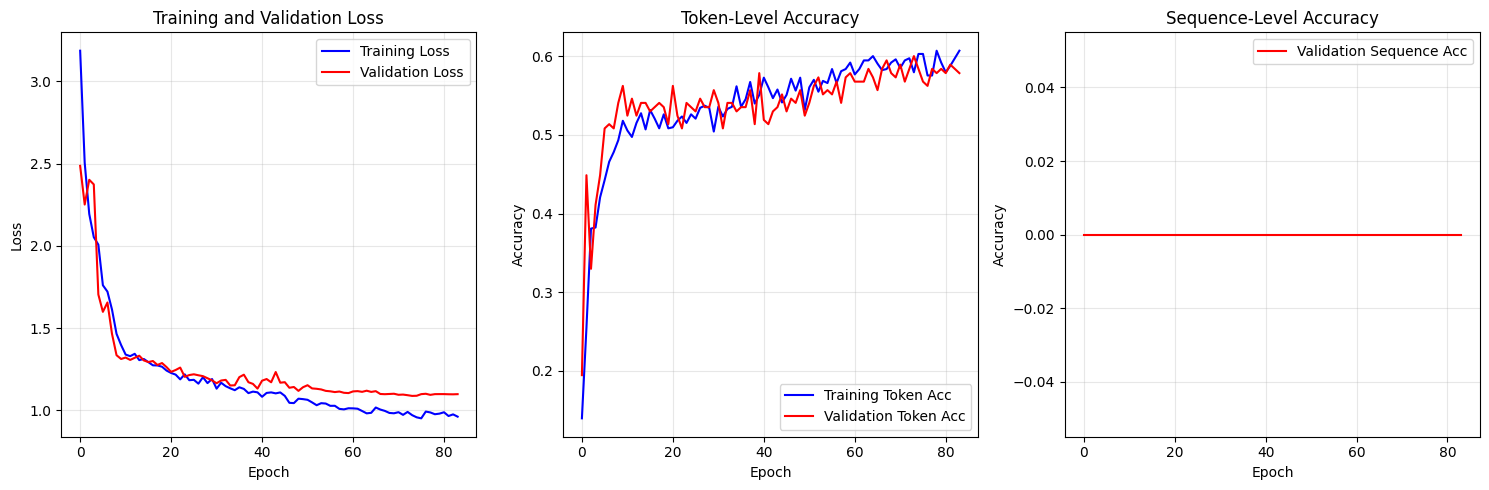

\n============================================================
FINAL EVALUATION
Final Validation Results:
  Loss: 1.0881
  Token Accuracy: 0.600 (60.0%)
  Sequence Accuracy: 0.000 (0.0%)
\nFinal Training Results:
  Loss: 0.9064
  Token Accuracy: 0.655 (65.5%)
  Sequence Accuracy: 0.009 (0.9%)
\n============================================================
GENERATION TESTING
Generation Test Results:
--------------------------------------------------------------------------------
Prompt: '0+'
  T=0.1: 0+2=2
  T=0.5: 0+1=3
  T=1.0: 0+0=2

Prompt: '1+'
  T=0.1: 1+0=1
  T=0.5: 1+2=3
  T=1.0: 1+6=8

Prompt: '2+'
  T=0.1: 2+8=1=9
  T=0.5: 2+7=10
  T=1.0: 2+1=3

Prompt: '3+'
  T=0.1: 3+4=8
  T=0.5: 3+0=3
  T=1.0: 3+6=10

Prompt: '4+'
  T=0.1: 4+4=9
  T=0.5: 4+4=9
  T=1.0: 4+2=7

Prompt: '5+'
  T=0.1: 5+6=12
  T=0.5: 5+0=5
  T=1.0: 5+6=13

Prompt: '5-'
  T=0.1: 5-2=3
  T=0.5: 5-0=4
  T=1.0: 5-5+9

Prompt: '7-'
  T=0.1: 7-5+4=2
  T=0.5: 7-4+4=3
  T=1.0: 7-3-2=4

Prompt: '9-'
  T=0.1: 9-5+4=4
  T=

In [17]:
# Visualize training history
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(training_history['train_loss'], label='Training Loss', color='blue')
plt.plot(training_history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Token accuracy
plt.subplot(1, 3, 2)
plt.plot(training_history['train_token_acc'], label='Training Token Acc', color='blue')
plt.plot(training_history['val_token_acc'], label='Validation Token Acc', color='red')
plt.title('Token-Level Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Sequence accuracy
plt.subplot(1, 3, 3)
plt.plot(training_history['val_seq_acc'], label='Validation Sequence Acc', color='red')
plt.title('Sequence-Level Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final evaluation on validation set
print("\\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)
final_val_loss, final_token_acc, final_seq_acc = evaluate_model(
    trained_model, val_loader, tokenizer, criterion, device)

print(f"Final Validation Results:")
print(f"  Loss: {final_val_loss:.4f}")
print(f"  Token Accuracy: {final_token_acc:.3f} ({final_token_acc*100:.1f}%)")
print(f"  Sequence Accuracy: {final_seq_acc:.3f} ({final_seq_acc*100:.1f}%)")

# Test on training set for comparison
final_train_loss, final_train_token_acc, final_train_seq_acc = evaluate_model(
    trained_model, train_loader, tokenizer, criterion, device)

print(f"\\nFinal Training Results:")
print(f"  Loss: {final_train_loss:.4f}")
print(f"  Token Accuracy: {final_train_token_acc:.3f} ({final_train_token_acc*100:.1f}%)")
print(f"  Sequence Accuracy: {final_train_seq_acc:.3f} ({final_train_seq_acc*100:.1f}%)")

# Generation testing
print("\\n" + "="*60)
print("GENERATION TESTING")
print("="*60)

def test_arithmetic_generation(model, tokenizer, test_cases, device):
    """Test model on specific arithmetic problems."""
    model.eval()
    results = []
    
    for prompt in test_cases:
        # Generate multiple samples for diversity
        generations = []
        for temp in [0.1, 0.5, 1.0]:  # Different temperatures
            generated = model.generate(tokenizer, prompt=prompt, 
                                     max_length=15, temperature=temp)
            full_expr = prompt + generated
            generations.append((temp, full_expr))
        
        results.append((prompt, generations))
    
    return results

# Test cases covering different scenarios
test_cases = [
    "0+", "1+", "2+", "3+", "4+", "5+",  # Addition
    "5-", "7-", "9-", "6-", "8-",        # Subtraction  
    "2+3", "4+5", "7+2",                 # Partial expressions
    "9+9", "8+7", "6+8",                 # Larger sums
]

# Run generation tests
generation_results = test_arithmetic_generation(trained_model, tokenizer, test_cases, device)

print("Generation Test Results:")
print("-" * 80)
for prompt, generations in generation_results:
    print(f"Prompt: '{prompt}'")
    for temp, full_expr in generations:
        print(f"  T={temp}: {full_expr}")
    print()

# Detailed analysis of specific examples
print("\\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

def analyze_arithmetic_correctness(expressions):
    """Analyze the mathematical correctness of generated expressions."""
    correct = 0
    total = 0
    errors = []
    
    for expr in expressions:
        total += 1
        try:
            # Parse the expression
            if '=' in expr:
                left, right = expr.split('=')
                
                if '+' in left:
                    operand1, operand2 = left.split('+')
                    expected = int(operand1) + int(operand2)
                elif '-' in left:
                    operand1, operand2 = left.split('-')
                    expected = int(operand1) - int(operand2)
                else:
                    continue
                
                actual = int(right)
                
                if actual == expected:
                    correct += 1
                else:
                    errors.append(f"{expr} (expected {expected})")
            
        except (ValueError, IndexError):
            errors.append(f"{expr} (parsing error)")
    
    return correct, total, errors

# Collect all generated expressions
all_expressions = []
for prompt, generations in generation_results:
    for temp, full_expr in generations:
        if '=' in full_expr:
            all_expressions.append(full_expr)

# Analyze correctness
correct, total, errors = analyze_arithmetic_correctness(all_expressions)

print(f"Mathematical Correctness Analysis:")
print(f"  Correct expressions: {correct}/{total} ({correct/total*100:.1f}%)")
print(f"  Errors found: {len(errors)}")

if errors:
    print(f"\\nFirst 10 errors:")
    for i, error in enumerate(errors[:10]):
        print(f"  {i+1}. {error}")

# Test with completely novel expressions
print("\\n" + "="*60)
print("NOVEL EXPRESSION TESTING")
print("="*60)

novel_prompts = ["1+7", "9-4", "6+6", "8-8", "4+4"]
print("Testing on expressions not in training data:")

for prompt in novel_prompts:
    # Check if this expression was in our training data
    full_expected = None
    for expr in data:
        if expr.startswith(prompt):
            full_expected = expr
            break
    
    generated = trained_model.generate(tokenizer, prompt=prompt, 
                                     max_length=10, temperature=0.1)
    full_generated = prompt + generated
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {full_generated}")
    print(f"In training: {'Yes' if full_expected else 'No'}")
    if full_expected:
        print(f"Expected: {full_expected}")
    print()

print("\\n🎉 Tutorial completed successfully!")
